# Exploratory Data Analysis

### Cleansing of the Dataset

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
import nltk
from nltk.corpus import stopwords

In [2]:
df = pd.read_csv("output/merged_chatgpt_weekly.csv")
df.shape

(752548, 6)

In [43]:
df.head()

,name,content,score,at,appversion,source_file
0,A Google user,supar,5,2025-06-07 23:59:52,1.2025.147,com.openai.chatgpt_weekly_20250601-20250607.csv
1,A Google user,Good ❤️👍,5,2025-06-07 23:59:09,1.2025.147,com.openai.chatgpt_weekly_20250601-20250607.csv
2,A Google user,not good,1,2025-06-07 23:58:23,1.2025.147,com.openai.chatgpt_weekly_20250601-20250607.csv
3,A Google user,life line,5,2025-06-07 23:57:25,1.2025.147,com.openai.chatgpt_weekly_20250601-20250607.csv
4,A Google user,amezing,5,2025-06-07 23:57:00,1.2025.126,com.openai.chatgpt_weekly_20250601-20250607.csv


In [5]:
df.dtypes

name           object
content        object
score           int64
at             object
appversion     object
source_file    object
dtype: object

In [7]:
df.isna().sum()

name               1
content            6
score              0
at                 0
appversion     51992
source_file        0
dtype: int64

In [8]:
df.duplicated().sum()

57

In [9]:
df_clean = df.copy()

In [10]:
df_clean = df_clean.drop_duplicates()

In [11]:
df_clean.duplicated().sum()

0

· 57 duplicate rows were removed to avoid repeated reviews.

In [12]:
df_clean = df_clean.dropna(subset=["content"])

In [14]:
df_clean["name"] = df_clean["name"].fillna("anonymous")

In [16]:
df_clean["appversion"] = df_clean["appversion"].fillna("unknown")

In [17]:
df_clean.isna().sum()

name           0
content        0
score          0
at             0
appversion     0
source_file    0
dtype: int64

· Reviews with missing textual content were dropped, as they do not contribute to sentiment or textual analysis. Missing user names were labeled as "anonymous", and missing app version metadata was filled with "unknown" to preserve valid reviews while enabling consistent grouping in downstream analysis. After cleaning, the dataset contains no missing values in key fields.

### Rating Distribution

In [18]:
df = df_clean.copy()
rating_counts = df["score"].value_counts().sort_index()
rating_counts

score
1     56614
2     15155
3     31540
4     74008
5    575168
Name: count, dtype: int64

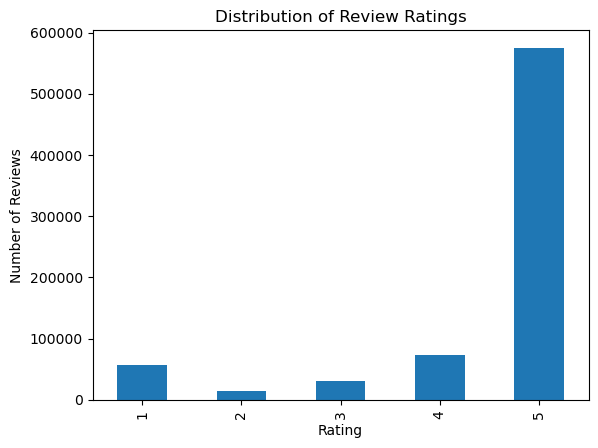

In [20]:
rating_counts.plot(kind="bar")
plt.xlabel("Rating")
plt.ylabel("Number of Reviews")
plt.title("Distribution of Review Ratings")
plt.show()

· The rating distribution shows a strong positive skew, with the majority of reviews concentrated at the highest rating level. Five-star reviews account for a disproportionately large share of the dataset, indicating generally favorable user sentiment toward the app. Lower ratings (two- and three-star reviews) are relatively less frequent but still substantial in absolute volume, suggesting the presence of meaningful user dissatisfaction. These lower-rated reviews are likely to contain more actionable feedback and will be examined more closely in subsequent analysis.


### Text length patterns

To investigate whether review verbosity is related to user sentiment, I constructed a text length feature by counting the number of words in each review’s textual content. I then grouped reviews by their star ratings and computed descriptive statistics for text length within each group.

In [25]:
df_clean["text_length"] = df_clean["content"].str.split().str.len()
df_clean["text_length"]

0         1
1         2
2         2
3         2
4         1
         ..
752543    1
752544    4
752545    6
752546    1
752547    3
Name: text_length, Length: 752485, dtype: int64

In [22]:
df_clean.groupby("score")["text_length"].describe()

,count,mean,std,min,25%,50%,75%,max
score,,,,,,,,
1,56614.0,13.050235,19.396501,1.0,2.0,5.0,14.0,128.0
2,15155.0,13.404619,21.026820,1.0,2.0,4.0,14.0,129.0
3,31540.0,9.417311,16.354517,1.0,1.0,3.0,9.0,122.0
4,74008.0,6.991501,12.321259,1.0,1.0,3.0,7.0,164.0
5,575168.0,5.104877,9.179884,1.0,1.0,2.0,5.0,169.0


First, lower-rated reviews tend to be longer on average. One-star and two-star reviews have the highest mean text lengths, indicating that dissatisfied users are more likely to write detailed explanations of their experiences.

Second, review length decreases consistently as ratings increase. Five-star reviews have the shortest median text length, suggesting that positive feedback is often brief and expressive rather than explanatory.

Third, all rating groups exhibit right-skewed distributions. The mean text length is substantially larger than the median across all ratings, implying that a small number of very long reviews inflate the average length.

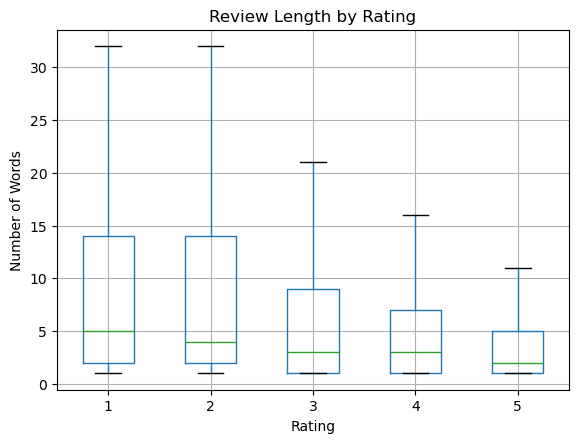

In [32]:
df_clean.boxplot(
    column="text_length",
    by="score",
    showfliers=False
)
plt.xlabel("Rating")
plt.ylabel("Number of Words")
plt.title("Review Length by Rating")
plt.suptitle("")
plt.show()

· I also visualized the distribution of review text length across different rating levels using a boxplot. The results show that lower-rated reviews tend to have higher median text lengths and greater variability, while higher-rated reviews, especially 5-star ratings, are generally shorter and more concentrated. This suggests that negative feedback is typically more detailed, whereas positive feedback is often brief.


### Frequency of keywords

In [34]:
# lowercase + remove non-letter characters
df_clean["clean_text"] = (
    df_clean["content"]
    .str.lower()
    .str.replace(r"[^a-z\s]", "", regex=True)
)

In [35]:
# tokenize
df_clean["tokens"] = df_clean["clean_text"].str.split()

In [37]:
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/iwi.whyyy/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [38]:
df_clean["tokens_filtered"] = df_clean["tokens"].apply(lambda x: [w for w in x if w not in stop_words])

· Stopwords were removed because they are high-frequency function words that do not carry semantic meaning relevant to user sentiment or app-related themes.

In [39]:
all_words = [
    word
    for tokens in df_clean["tokens_filtered"]
    for word in tokens
]

word_freq = Counter(all_words)
word_freq.most_common(20)

[('good', 195073),
 ('app', 149743),
 ('nice', 81996),
 ('best', 70798),
 ('ai', 34058),
 ('helpful', 31465),
 ('chatgpt', 28616),
 ('love', 28427),
 ('great', 28351),
 ('like', 27597),
 ('chat', 20121),
 ('excellent', 19824),
 ('useful', 19682),
 ('amazing', 19654),
 ('super', 19238),
 ('gpt', 18880),
 ('use', 18226),
 ('really', 16391),
 ('help', 14075),
 ('hai', 13133)]

· The most common keywords are overwhelmingly positive, with words such as “good”, “nice”, “best”, “great”, “excellent”, “useful”, and “amazing” appearing most frequently. App-specific terms including “app”, “chatgpt”, “chat”, “ai”, and “gpt” also rank highly.

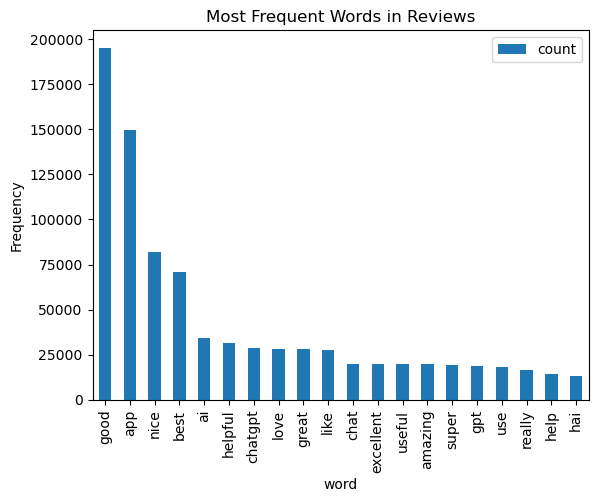

In [42]:
top_words = pd.DataFrame(
    word_freq.most_common(20),
    columns=["word", "count"]
)

top_words.set_index("word").plot(kind="bar")
plt.title("Most Frequent Words in Reviews")
plt.ylabel("Frequency")
plt.show()

In [41]:
low_reviews = df_clean[df_clean["score"] <= 2]
high_reviews = df_clean[df_clean["score"] >= 4]

low_words = Counter(
    word
    for tokens in low_reviews["tokens_filtered"]
    for word in tokens
)

high_words = Counter(
    word
    for tokens in high_reviews["tokens_filtered"]
    for word in tokens
)
low_words.most_common(10), high_words.most_common(10)

([('app', 13897),
  ('good', 10858),
  ('bad', 5303),
  ('time', 4614),
  ('chatgpt', 4379),
  ('like', 4249),
  ('nice', 4034),
  ('ai', 3969),
  ('gpt', 3819),
  ('cant', 3783)],
 [('good', 173995),
  ('app', 130970),
  ('nice', 74841),
  ('best', 67688),
  ('helpful', 29659),
  ('ai', 28994),
  ('love', 27229),
  ('great', 26398),
  ('chatgpt', 22849),
  ('like', 21662)])

· To further examine differences in review content, I compared the most frequent keywords between low-rated reviews (1–2 stars) and high-rated reviews (4–5 stars). Although keyword frequency analysis was performed, the resulting vocabulary is largely dominated by very generic sentiment words such as “good”, “bad”, and “can’t”. Beyond these terms, most remaining high-frequency words (e.g., “app”, “chatgpt”, “ai”) are descriptive rather than analytically informative.

### Temporal Pattern

To understand how user feedback evolved over time, I aggregated reviews at a monthly level and examined both review volume and average rating trends.

In [44]:
df_clean["at"] = pd.to_datetime(df_clean["at"], errors="coerce")

In [45]:
df_clean["year_month"] = df_clean["at"].dt.to_period("M")

In [48]:
monthly_counts = (
    df_clean
    .groupby("year_month")
    .size()
    .reset_index(name="num_reviews")
)
monthly_counts

,year_month,num_reviews
0,2025-06,152710
1,2025-07,147637
2,2025-08,145172
3,2025-09,127875
4,2025-10,94443
5,2025-11,82021
6,2025-12,2627


In [49]:
monthly_avg_rating = (
    df_clean
    .groupby("year_month")["score"]
    .mean()
    .reset_index(name="avg_rating")
)
monthly_avg_rating

,year_month,avg_rating
0,2025-06,4.514177
1,2025-07,4.529617
2,2025-08,4.430896
3,2025-09,4.414154
4,2025-10,4.371896
5,2025-11,4.427208
6,2025-12,4.414161


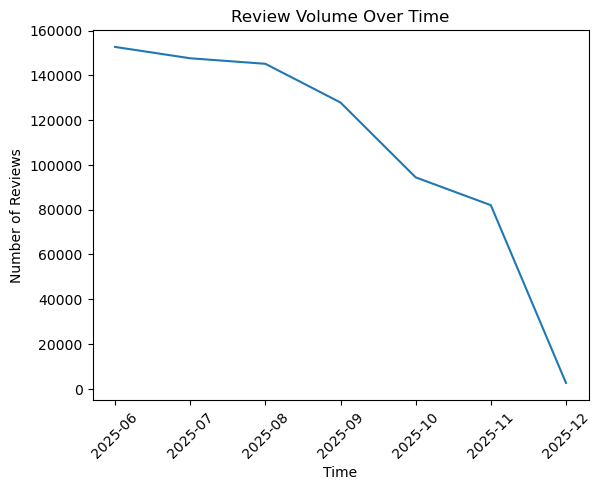

In [50]:
plt.figure()
plt.plot(
    monthly_counts["year_month"].astype(str),
    monthly_counts["num_reviews"]
)
plt.xticks(rotation=45)
plt.xlabel("Time")
plt.ylabel("Number of Reviews")
plt.title("Review Volume Over Time")
plt.show()

· I analyzed the temporal distribution of reviews by aggregating the number of reviews per month. The results show a clear downward trend in review volume over time. Review activity was highest between June and August 2025, exceeding 140k reviews per month, and then declined steadily through the fall. By December 2025, the number of reviews dropped sharply.

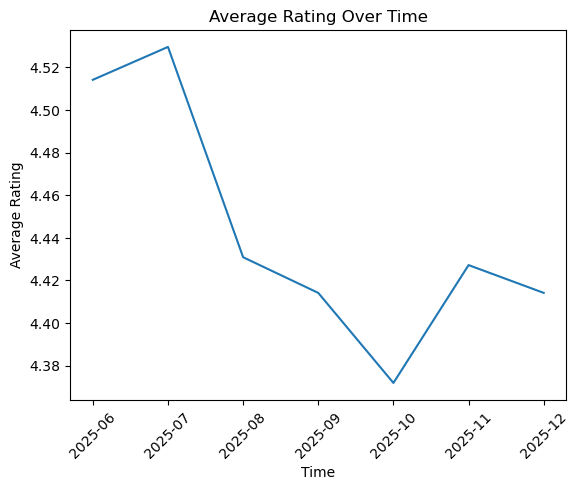

In [51]:
plt.figure()
plt.plot(
    monthly_avg_rating["year_month"].astype(str),
    monthly_avg_rating["avg_rating"]
)
plt.xticks(rotation=45)
plt.xlabel("Time")
plt.ylabel("Average Rating")
plt.title("Average Rating Over Time")
plt.show()

· Average ratings remained relatively stable across months, staying within a narrow range between approximately 4.37 and 4.53. There is a mild downward trend from July to October 2025, followed by a slight recovery in November.

### Text Length Outlier

In [52]:
Q1 = df_clean["text_length"].quantile(0.25)
Q3 = df_clean["text_length"].quantile(0.75)
IQR = Q3 - Q1

upper_bound = Q3 + 1.5 * IQR

text_length_outliers = df_clean[df_clean["text_length"] > upper_bound]

len(text_length_outliers), upper_bound

(76742, 13.5)

In [53]:
len(text_length_outliers) / len(df_clean)

0.1019847571712393

In [54]:
text_length_outliers["score"].value_counts().sort_index()

score
1    14858
2     3841
3     5696
4     9473
5    42874
Name: count, dtype: int64

· Using the IQR method, I identified reviews with text length greater than 13.5 words as outliers, resulting in 76,742 reviews classified as text length outliers.

These outliers account for approximately 10.2% of the dataset, indicating that longer reviews are relatively common rather than extremely rare in this corpus.

Examining the rating distribution of these outliers shows that they appear across all rating levels, with a strong concentration in 5-star reviews, suggesting that both highly positive and highly negative user experiences tend to generate longer, more detailed feedback.

### Rating - Text Outlier

In [55]:
long_text_threshold = df_clean["text_length"].quantile(0.95)

unexpected_long_positive = df_clean[
    (df_clean["score"] == 5) &
    (df_clean["text_length"] > long_text_threshold)
]

unexpected_long_negative = df_clean[
    (df_clean["score"] <= 2) &
    (df_clean["text_length"] > long_text_threshold)
]

len(unexpected_long_positive), len(unexpected_long_negative)

(17763, 11456)

In [57]:
unexpected_long_negative[["score", "text_length", "content"]].head(5)

,score,text_length,content
296,1,88,"es buena app, pero el exceso de censura se con..."
438,2,78,I’m reaching out to express my concern regardi...
478,1,86,"it's the worst app I've ever used, I'm still u..."
481,2,41,expected more. Does the bare minimum and that'...
812,2,27,very slow and good for small codes not good fo...


· Using the 95th percentile of text length as a threshold, I identified unexpectedly long 5-star reviews (17,763), indicating that a substantial number of highly positive users still provide unusually detailed feedback.

Similarly, I found 11,456 low-rating (≤2 stars) reviews with exceptionally long text, suggesting that negative experiences also frequently lead to extended, explanatory comments.

### Early signals of sentiment trends

In [58]:
monthly_sentiment_share = (
    df_clean
    .assign(
        low_rating = df_clean["score"] <= 2,
        high_rating = df_clean["score"] == 5
    )
    .groupby("year_month")[["low_rating", "high_rating"]]
    .mean()
    .reset_index()
)

monthly_sentiment_share

,year_month,low_rating,high_rating
0,2025-06,0.082274,0.781985
1,2025-07,0.078673,0.787140
2,2025-08,0.101810,0.757226
3,2025-09,0.104938,0.752117
4,2025-10,0.116049,0.740690
5,2025-11,0.099523,0.750162
6,2025-12,0.102018,0.743434


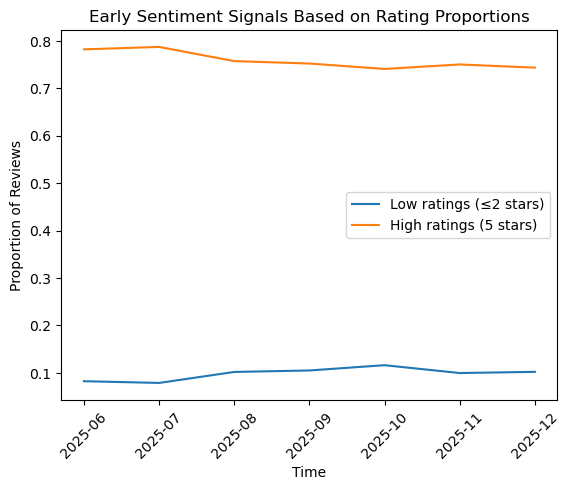

In [59]:
plt.figure()
plt.plot(
    monthly_sentiment_share["year_month"].astype(str),
    monthly_sentiment_share["low_rating"],
    label="Low ratings (≤2 stars)"
)
plt.plot(
    monthly_sentiment_share["year_month"].astype(str),
    monthly_sentiment_share["high_rating"],
    label="High ratings (5 stars)"
)
plt.xticks(rotation=45)
plt.ylabel("Proportion of Reviews")
plt.xlabel("Time")
plt.title("Early Sentiment Signals Based on Rating Proportions")
plt.legend()
plt.show()

· I computed the monthly proportion of low ratings (≤ 2 stars) and high ratings (5 stars) as a simple heuristic to capture early sentiment signals over time. The results show that high ratings consistently dominate across all months, while low ratings remain a relatively small fraction of total reviews.
I also visualized these rating proportions over time to better observe sentiment dynamics. The plot highlights that although positive sentiment remains strong overall, there is a temporary period where negative feedback becomes more frequent and positive feedback slightly declines.

In [60]:
monthly_low_length = (
    df_clean[df_clean["score"] <= 2]
    .groupby("year_month")["text_length"]
    .mean()
    .reset_index(name="avg_low_rating_length")
)

monthly_low_length

,year_month,avg_low_rating_length
0,2025-06,10.168179
1,2025-07,12.041326
2,2025-08,14.721854
3,2025-09,12.725613
4,2025-10,14.822263
5,2025-11,14.683940
6,2025-12,13.764925


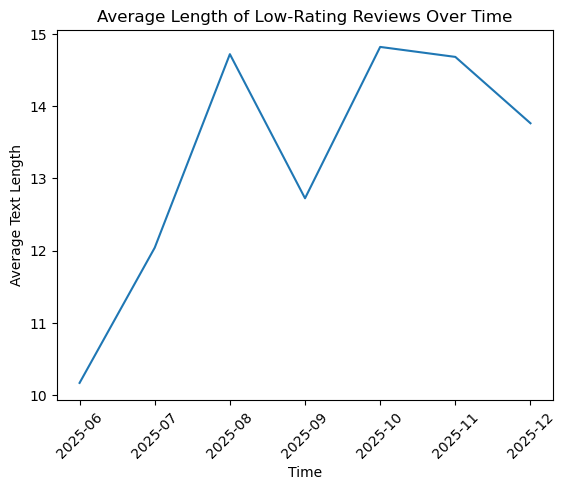

In [61]:
plt.figure()
plt.plot(
    monthly_low_length["year_month"].astype(str),
    monthly_low_length["avg_low_rating_length"]
)
plt.xticks(rotation=45)
plt.xlabel("Time")
plt.ylabel("Average Text Length")
plt.title("Average Length of Low-Rating Reviews Over Time")
plt.show()

· I computed the monthly average text length for low-rating reviews (≤2 stars) to examine whether dissatisfied users tend to write longer feedback over time. The results show that the average length of low-rating reviews generally increased from mid-2025 to late-2025, suggesting that negative feedback became more detailed during this period. I also visualized the average length of low-rating reviews over time to better capture the trend. The line plot shows a clear rise in review length from June to August, followed by fluctuations at a relatively high level, indicating sustained user engagement in expressing negative experiences rather than brief complaints. This pattern suggests a potential early warning signal: while overall ratings remain relatively stable, users who leave low ratings are spending more effort articulating their dissatisfaction.